# Reproducing Gunseli CDA Study (2019)
## Pipeline for all files

Note: No cleaning, no trial nor subject removal. All data is taken/used.
Note: They average differently in their study. They average all good contra trials over electrode and then substract contra - ipsi. I substract electrodes and then average over trials.  

- pp11 to be removed.
- pp24 causing trouble for cue = 5
- pp18 causing trouble for cue = 6

... to investigate vs Matlab .mat files

- I'm not using the behav files, I probably should!

In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import copy

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_eeglab

import sys
#sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/')
sys.path.append('D:\\PhD\\CDA-review\\studies\\')
from cda_utils import get_epochs, get_CDA, prep_report, fill_report, get_report, checksum, add_cda_report, get_CDA_perf_report
#sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Gunseli-2019/')
sys.path.append('D:\\PhD\\CDA-review\\studies\\Gunseli-2019\\')
from events import get_specific_events
 
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [2]:
#==================================================================
# General Variables
#==================================================================
triggers = dict();

triggers['5'] = [5] 
triggers['6'] = [6]

triggers['left'] = [10]
triggers['right'] = [20]
triggers['TBD'] = [30, 255]  # 255 is only for pp24 which doesn't have '30' but '255'

triggers['good'] = []
triggers['bad'] = []

# Labels
conds = ['5', '6']
sides = ['left', 'right', 'TBD']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['P8', 'PO8', 'O2']
chan_left = ['P7', 'PO7', 'O1']

# Epoc Information
epoch_length = 1.2
epoch_tmin = -0.5
baseline_corr = (-0.2, 0)

# # CDA main variable & Reports
cda_dict = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
folderpath = '/Users/nick/Documents/PhD/CDA Datasets/Gunseli 2019/'
filepath = folderpath + 'raw data files/' + 'StratAtt_e2_LoadChans_pp11.set'

#for filepath in glob.iglob(folderpath + 'raw data files/' + '*.set'):
filename = filepath[filepath.rfind('/')+1:]
print('Processing: ' + filename + '...')

# 1. -- Load File --
raw = read_raw_eeglab(filepath, preload=True)

# Resample
preproc = raw.resample(500)

# 2. -- General Preprocess --
# Keep only EEG channels and reference
#raw = raw.set_eeg_reference(ref_channels=['EXG7', 'EXG8'])

# Set Electrodes Locations
#montage = mne.channels.make_standard_montage('biosemi64')
#raw.set_montage(montage)

# Filter
preproc = preproc.filter(.1, 6., fir_design='firwin')

# Get events
events = mne.events_from_annotations(preproc)

#preproc.plot(events=events[0], block=True, lowpass=40)

# ------------------------
# 3. -- Epochs --
# ------------------------
#behavfilepath = folderpath + 'raw data files/' + 'subject-{}.csv'.format(filepath[filepath.rfind('pp')+2:filepath.rfind('.')])

#behav = pd.read_csv(behavfilepath)  
#behav_hl = behav['block_type'][(behav['block_type'] == 'low') | (behav['block_type'] == 'high')]

print('=================================')
print(events)
print('=================================')

# Redo Triggers based on annotation in file!
new_triggers = copy.deepcopy(triggers)
for k in new_triggers.keys():
    for i,t in enumerate(new_triggers[k]):
        if str(t) in events[1].keys():
            new_triggers[k][i] = events[1][str(t)]
specific_events = get_specific_events(events[0], conds, sides, perfs, new_triggers)

epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

# ------------------------
# 4. - Report & Checksum -
# ------------------------
report = fill_report(report, filename, specific_events)
report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)

# ------------------------
# 5. -- CDA --
# ------------------------
cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)

# Add time points to CDA for later use.
cda_dict['times'] = epochs_dict['5']['left']['good'].times

subreport = get_report(report, ['5','6'], ['left','right'], ['good'], [])
report

Processing: StratAtt_e2_LoadChans_pp11.set...
Reading /Users/nick/Documents/PhD/CDA Datasets/Gunseli 2019/raw data files/StratAtt_e2_LoadChans_pp11.fdt
Reading 0 ... 2301951  =      0.000 ...  4495.998 secs...


/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_20749/3640497324.py:45: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['VEOGsT', 'VEOGsB', 'HEOGsL', 'HEOGsR']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_eeglab(filepath, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 6 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 6.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Filter length: 16501 samples (33.002 sec)

Used Annotations descriptions: ['1', '10', '20', '30', '5', '6']
(array([[   6730,       0,       1],
       [   7544,       0,       6],
       [   8062,       0,       4],
       ...,
       [2238778,       0,       1],
       [2239456,       0,       5],
       [2239975,       0,       3]]), {'1': 1, '10': 2, '20': 3, '30': 4, '5': 5, '6': 6})
Found: 6 at 7544
Found: 6 at 11150
Found: 6 at 14916
Found: 6 at 18256
Found: 6 at 2319

Not setting metadata
500 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 500 events and 851 original time points ...


/Users/nick/Documents/PhD/CLCT/reprod/studies/Gunseli-2019/eventx.py:103: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  all_epochs = Epochs(eeg, all_events, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')


0 bad epochs dropped
A total of 500 epochs were extracted and baseline corrected.
---------- 5-left-good -------------
---------- 5-left-bad -------------
---------- 5-right-good -------------
---------- 5-right-bad -------------
---------- 5-TBD-good -------------
---------- 5-TBD-bad -------------
---------- 6-left-good -------------
---------- 6-left-bad -------------
---------- 6-right-good -------------
---------- 6-right-bad -------------
---------- 6-TBD-good -------------
---------- 6-TBD-bad -------------
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum FAILED! Length mismatch for: 5-left-good (79 events vs 167 epochs)
Checksum FAILED! Length mismatch for: 5-right-good (86 events vs 151 epochs)
Checksum FAILED! Length mismatch for: 5-TBD-good (85 events vs 182 epochs)
Checksum FAILED! Length mismatch for: 6-left-good (88 events vs 167 epochs)
Checksum FAILED! Length mismatch for: 6-right-good (65 events vs 151 epochs)
Ch

,5,6,left,right,TBD,good,bad,5-left,5-left-good,5-good,...,6-left-bad,6-bad,6-right,6-right-good,6-right-bad,6-TBD,6-TBD-good,6-TBD-bad,checksum,notes
StratAtt_e2_LoadChans_pp11.set,250,250,167,151,182,500,0,79,79,250,...,0,0,65,65,0,97,97,0,0,


In [3]:
evs = events[0]
evs[(evs[:, 0] > 1258259) & (evs[:, 0] < 1275985)]

array([[1258777,       0,       4],
       [1260952,       0,       1],
       [1261766,       0,       5],
       [1262284,       0,       4],
       [1265063,       0,       1],
       [1265874,       0,       5],
       [1266393,       0,       2],
       [1268943,       0,       1],
       [1269606,       0,       5],
       [1270125,       0,       2],
       [1272309,       0,       1],
       [1273071,       0,       5],
       [1273590,       0,       4],
       [1275346,       0,       1]])

## 2. Save CDA Data

In [ ]:
#====================================
# Save the whole CDA dict.
#====================================
with open("cda_gunseli2019_raw.pkl","wb") as f:
    pickle.dump(cda_dict, f)

## 3. Load CDA Data

In [2]:
with open("cda_gunseli2019_raw.pkl","rb") as f:
    cda_dict = pickle.load(f)

times = cda_dict['times']
del cda_dict['times']

print("Participants: {}, Conditions: {}". format(len(cda_dict), cda_dict[list(cda_dict.keys())[0]].keys()))

Participants: 30, Conditions: dict_keys(['5', '6'])


## 4. Plot CDA Data - Grand CDA Average

In [3]:
cda_all = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict.keys():
        ## ====== Manual Cleanup ========
        # TODO: Skip only 1 side.
        # TODO: Look at pp24 cue 6
        # TODO: Look at pp18 cue 5
        if (f == 'StratAtt_e2_LoadChans_pp11.set') or (f == 'StratAtt_e2_LoadChans_pp18.set' and cond == '5') or (f == 'StratAtt_e2_LoadChans_pp24.set' and cond == '6'):
        #if (f == 'StratAtt_e2_LoadChans_pp11.set'):# or (f == 'StratAtt_e2_LoadChans_pp18.set') or (f == 'StratAtt_e2_LoadChans_pp24.set'):
            print('Manual Skip...')
            continue
        
        perf = 'good'
        ldict = cda_dict[f][cond]['left']
        rdict = cda_dict[f][cond]['right']
        if (perf in ldict.keys() and len(ldict[perf])) and (perf in rdict.keys() and len(rdict[perf])):            
            cda_dict_cur = (cda_dict[f][cond]['left']['good'] + cda_dict[f][cond]['right']['good'])/2
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))
            
        #print("Processing CDA ({}): {}-{} = {}, {}-{} = {}".format(f, cond, 'left', len(ldict), cond, 'right', len(rdict)))

Manual Skip...
Manual Skip...
Manual Skip...
Manual Skip...


## Final CDA figure from Gunseli 2019

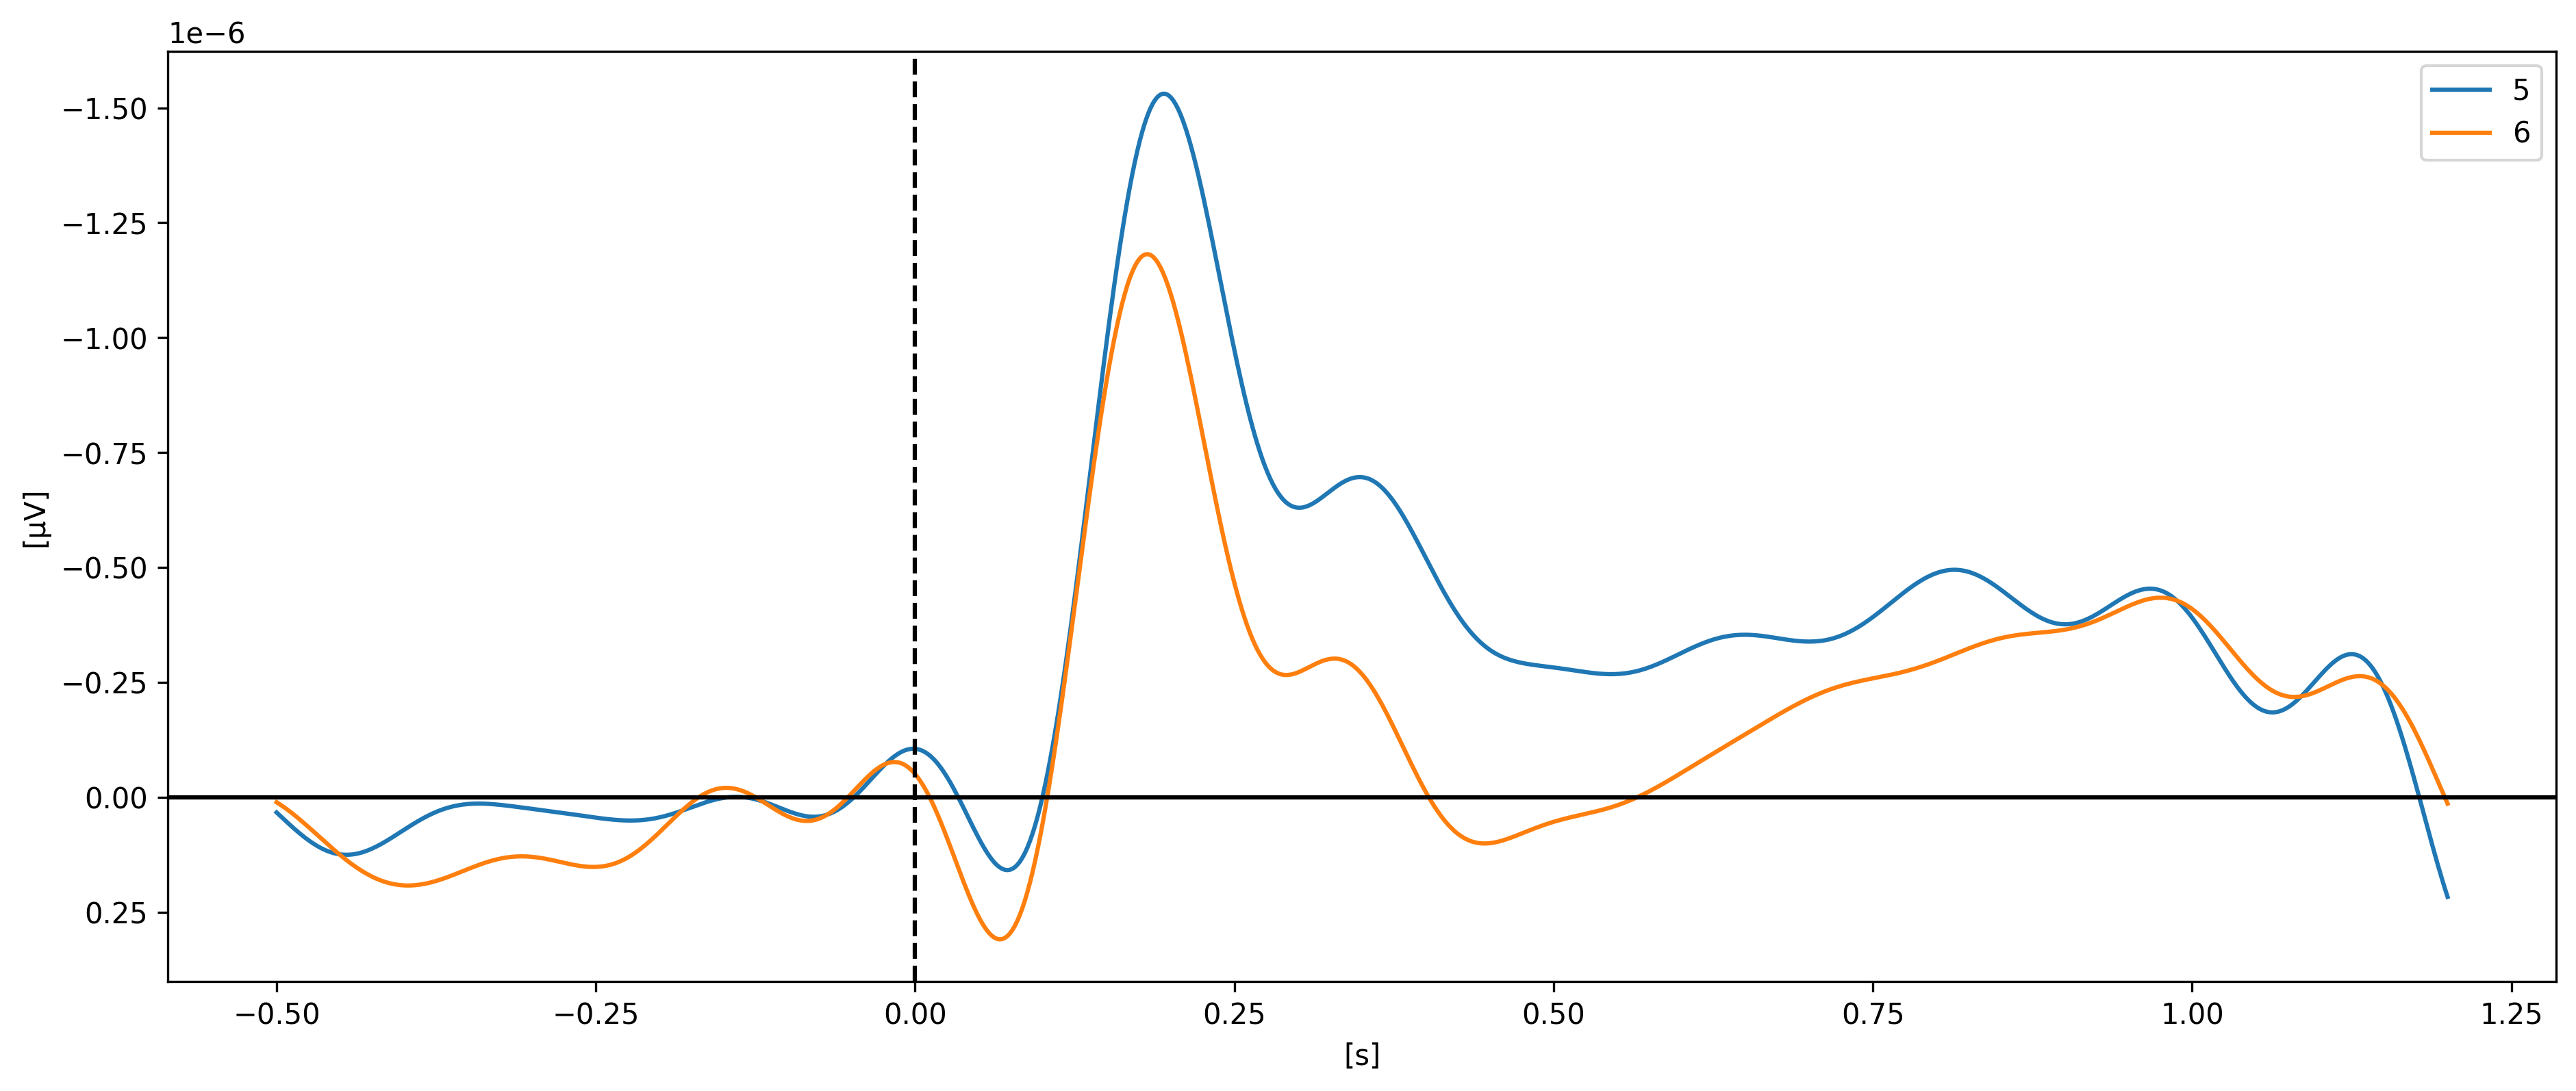

In [4]:
plt.figure(figsize=(15, 6), dpi=300)
plt.plot(times, cda_all['5'].mean(0), label='5')
plt.plot(times, cda_all['6'].mean(0), label='6')

plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.savefig("Gunseli-2019_CDA-reprod.png", dpi=300, format='png')

## The difference between the paper and the graph below:
#1 - No subject rejected here.  (only 1 above, removed from the 15-25)
#2 - No artifact removal!
#3 - No Channel interpolation for noisy channel.
#4 - Not a 6Hz Low Pass filter at for their final graph.

# Gunseli 2019 from Matlab Files
Can't reproduce same resuslts from the raw files, nor their preprocessed files.
There are other files that seemed to have received more preprocessing and massaging and indeed then I can reproduce.

In [6]:
import mat73
import numpy as np
import pandas as pd
import glob

import os
import sys

import matplotlib.pyplot as plt
%matplotlib inline

#==================================================================
# General Variables
#==================================================================
triggers = dict();

triggers['5'] = [5] 
triggers['6'] = [6]

triggers['left'] = [10]
triggers['right'] = [20]
triggers['TBD'] = [30, 255]  # 255 is only for pp24 which doesn't have '30' but '255'

triggers['good'] = []
triggers['bad'] = []

# Labels
conds = ['5', '6']
sides = ['left', 'right', 'TBD']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['P8', 'PO8', 'O2']
chan_left = ['P7', 'PO7', 'O1']

cda_all_matlab = dict()
cda_all_matlab['5'] = np.array([])
cda_all_matlab['6'] = np.array([])

participants = [i for i in range(33) if i not in [0,1,20,27]]
participant = 4
#folderpath = '/Users/nick/Documents/PhD/CDA Datasets/Gunseli 2019/'
folderpath = 'D:\\CLNT\\Data\\Open Datasets\\Gunseli 2019\\'
for participant in participants:
    filepath = folderpath + 'processed data files/{}_EEG_cueOnset.mat'.format(participant)
    
    # Keep only clean ones...
    mat_data = mat73.loadmat(filepath)
    idx_to_remove = mat_data['erp']['arf']['artifactIndCleaned']
    idx_to_keep = np.invert(idx_to_remove)
    
    filepath = folderpath + 'processed data files/{}_EEG_cueOnset_6HzLowPass.mat'.format(participant)
    #filepath = folderpath + 'processed data files/{}_EEG_cueOnset_longEpoch.mat'.format(participant)
    print('Processing: {}'.format(filepath))

    mat_data = mat73.loadmat(filepath)
    data = mat_data['erp']['data']
    codes = mat_data['erp']['codes']
    times = mat_data['erp']['times']

    codes = codes[idx_to_keep]
    data = data[idx_to_keep,:,:]
    
    # Reconstruct epochs 
    epochs_dict = dict()
    for cond in conds:
        epochs_dict[cond] = dict()
        for side in sides:
            epochs_dict[cond][side] = dict()
            for perf in ['good']: #perfs:
                new_trigger = triggers[cond][0] + triggers[side][0]
                epochs_dict[cond][side][perf] = data[codes == new_trigger,:,:]

                total = 0
                
    # Checksum on total epochs!
    for cond in conds:
        for side in sides:
            for perf in ['good']: #perfs:
                total = total + len(epochs_dict[cond][side][perf])
                
    idx_right = [i for i in range(68) if mat_data['erp']['chanlocs'][i]['labels'] in chan_right]
    idx_left = [i for i in range(68) if mat_data['erp']['chanlocs'][i]['labels'] in chan_left]
    #print('Chan Left: {}  |  Chan Right: {}'.format(idx_left, idx_right))
    
    cda_dict = dict()
    for cond in conds:
        cda_dict[cond] = dict()
        for side in sides:
            cda_dict[cond][side] = dict()
            for perf in ['good']: #perfs:
                if side == 'left':
                    cda_dict[cond][side][perf] = epochs_dict[cond][side][perf][:,idx_left,:] - epochs_dict[cond][side][perf][:,idx_right,:]
                else:
                    cda_dict[cond][side][perf] = epochs_dict[cond][side][perf][:,idx_right,:] - epochs_dict[cond][side][perf][:,idx_left,:]

                cda_dict[cond][side][perf] = cda_dict[cond][side][perf].mean(1).mean(0)

        cda_cur = (cda_dict[cond]['left']['good'] + cda_dict[cond]['right']['good']) / 2
        cda_all_matlab[cond] = np.vstack([cda_all_matlab[cond], cda_cur]) if len(cda_all_matlab[cond]) else cda_cur
    
    print('Participant: {} has {} epochs! (times={})'.format(participant, total, len(times)))


Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/2_EEG_cueOnset_6HzLowPass.mat
Participant: 2 has 415 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/3_EEG_cueOnset_6HzLowPass.mat
Participant: 3 has 399 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/4_EEG_cueOnset_6HzLowPass.mat
Participant: 4 has 345 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/5_EEG_cueOnset_6HzLowPass.mat
Participant: 5 has 423 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/6_EEG_cueOnset_6HzLowPass.mat
Participant: 6 has 468 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/7_EEG_cueOnset_6HzLowPass.mat
Participant: 7 has 448 epochs! (times=1001)
Processing: D:\CLNT\Data\Open Datasets\Gunseli 2019\processed data files/8_EEG_cueOnset_6HzLowPass.mat
Participant: 8 

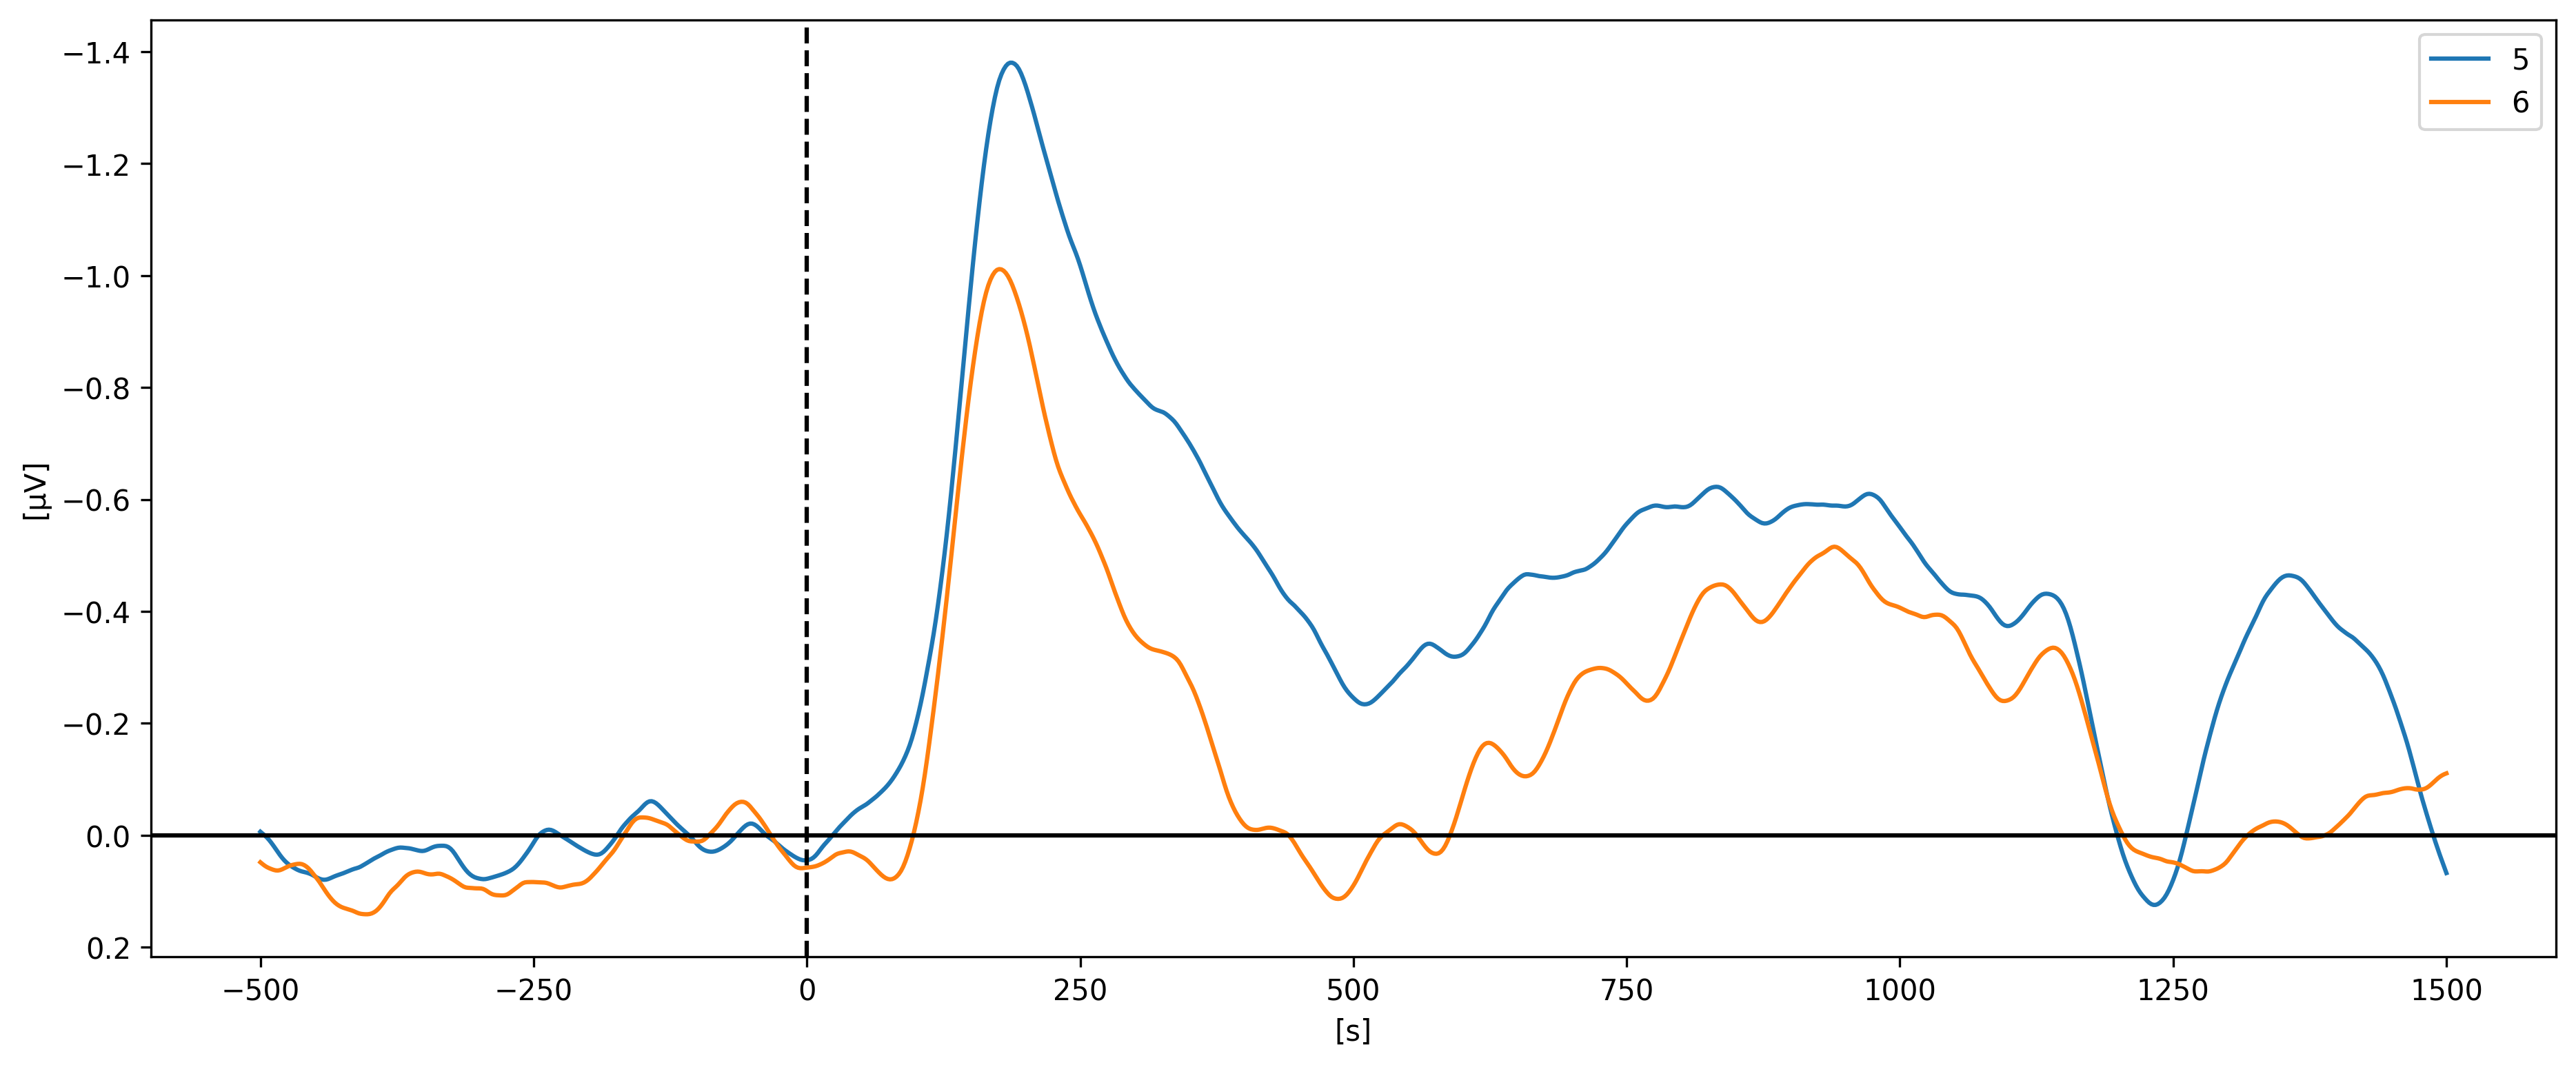

In [7]:
plt.figure(figsize=(15, 6), dpi=300)
plt.plot(times, cda_all_matlab['5'].mean(0), label='5')
plt.plot(times, cda_all_matlab['6'].mean(0), label='6')

plt.axvline(x=0, color='k', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[s]')
plt.show()

# Comp. Plot

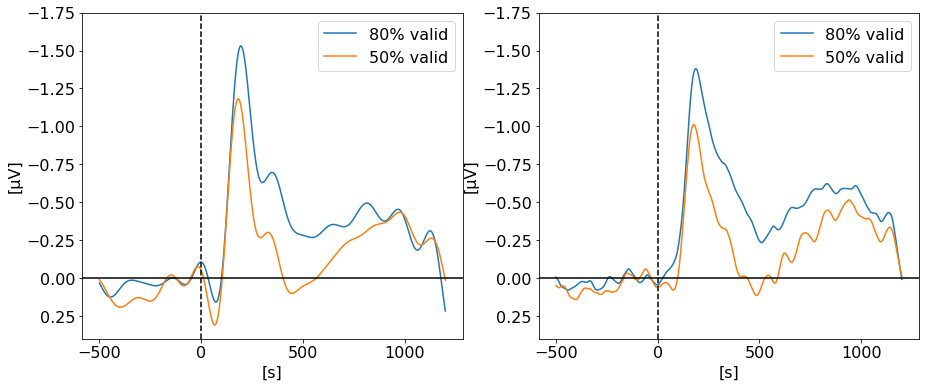

In [8]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 2, figsize=(15,6))

# use only 1.2s epoch data, not 1.5s
nb_points = cda_all['5'].shape[1]
times = times[:nb_points]
cda_all_matlab['5'] = cda_all_matlab['5'][:,:nb_points]
cda_all_matlab['6'] = cda_all_matlab['6'][:,:nb_points]

# 2. Plot Figure #1
axs[0].plot(times, cda_all['5'].mean(0) * 10e5, label='80% valid')
axs[0].plot(times, cda_all['6'].mean(0) * 10e5, label='50% valid')
axs[0].axvline(x=0, color='k', linestyle='--')
axs[0].axhline(y=0, color='k', linestyle='-')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_ylabel('[μV]')
axs[0].set_xlabel('[s]')
axs[0].set_ylim([0.4, -1.75])

# 2. Plot Figure #2
cda_all_matlab['5'] = cda_all_matlab['5']
axs[1].plot(times, cda_all_matlab['5'].mean(0), label='80% valid')
axs[1].plot(times, cda_all_matlab['6'].mean(0), label='50% valid')
axs[1].axvline(x=0, color='k', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_ylabel('[μV]')
axs[1].set_xlabel('[s]')
axs[1].set_ylim([0.4, -1.75])

plt.savefig("./Gunseli-2019_CDA-reprod-comp.png", dpi=300, format='png')

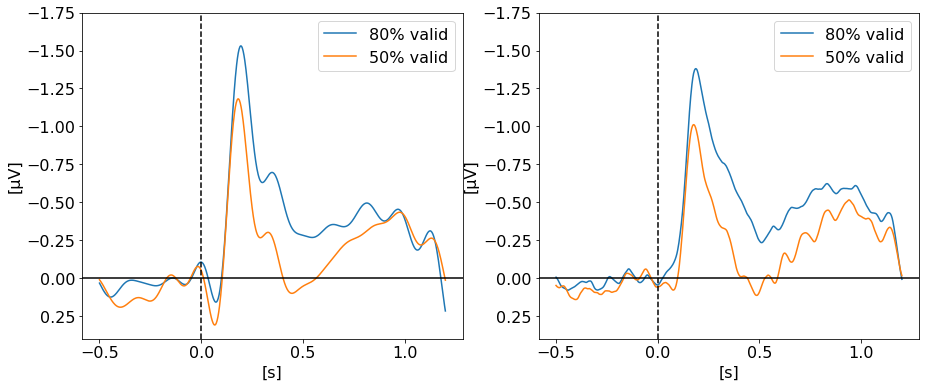

In [78]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 2, figsize=(15,6))

# use only 1.2s epoch data, not 1.5s
nb_points = cda_all['5'].shape[1]
times = times[:nb_points]
cda_all_matlab['5'] = cda_all_matlab['5'][:,:nb_points]
cda_all_matlab['6'] = cda_all_matlab['6'][:,:nb_points]

# 2. Plot Figure #1
axs[0].plot(times, cda_all['5'].mean(0) * 10e5, label='80% valid')
axs[0].plot(times, cda_all['6'].mean(0) * 10e5, label='50% valid')
axs[0].axvline(x=0, color='k', linestyle='--')
axs[0].axhline(y=0, color='k', linestyle='-')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_ylabel('[μV]')
axs[0].set_xlabel('[s]')
axs[0].set_ylim([0.4, -1.75])

# 2. Plot Figure #2
cda_all_matlab['5'] = cda_all_matlab['5']
axs[1].plot(times, cda_all_matlab['5'].mean(0), label='80% valid')
axs[1].plot(times, cda_all_matlab['6'].mean(0), label='50% valid')
axs[1].axvline(x=0, color='k', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_ylabel('[μV]')
axs[1].set_xlabel('[s]')
axs[1].set_ylim([0.4, -1.75])

plt.savefig("./Gunseli-2019_CDA-reprod-comp.png", dpi=300, format='png')